# Students IDs: 211896261 322593070 322642752
### Notebook runned in the Google Colab environment, no special installations needed, only uploading the csvs to the sample_data folder.

# Question 1:

In [ ]:
import pandas as pd

def Load(filename, year):
    interactions_df = pd.read_csv(filename)
    year = int(year)
    interactions_df['date'] = pd.to_datetime(interactions_df['date'], dayfirst=True)
    interactions_df['Year'] = interactions_df['date'].dt.year

    interactions_df = interactions_df[interactions_df['Year'] == year]
    user_counts = interactions_df['user_id'].value_counts()
    valid_users = user_counts[user_counts >= 2].index

    recipe_counts = interactions_df['recipe_id'].value_counts()
    valid_recipes = recipe_counts[recipe_counts >= 2].index

    interactions_df = interactions_df[
        interactions_df['user_id'].isin(valid_users) &
        interactions_df['recipe_id'].isin(valid_recipes)
    ]
    return interactions_df

# Question 2:

In [ ]:
import pandas as pd

def Split_Train_Test(df, train_ratio=0.75, n_splits=5):
    df = df.sort_values(by=["Year"]).reset_index(drop=True)

    total_len = len(df)
    fold_size = total_len // n_splits

    splits = []
    for i in range(n_splits):
        test_start = i * fold_size + int(fold_size * train_ratio)
        test_end = (i + 1) * fold_size

        train_start = 0
        train_end = test_start

        train = df.iloc[train_start:train_end]
        test = df.iloc[test_start:test_end]
        splits.append((train, test))

    return splits

# Question 3:

In [ ]:
def Split_Train_Test_Users(df, train_ratio=0.75):
    train_list, test_list = [], []
    for user_id, user_df in df.groupby('user_id'):
        if len(user_df) < 2:
            continue
        user_df = user_df.sort_values('date')
        split_index = int(len(user_df) * train_ratio)
        if split_index == 0:
            continue
        train_list.append(user_df.iloc[:split_index])
        test_list.append(user_df.iloc[split_index:])

    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    seen_recipes = set(train_df['recipe_id'])
    test_df = test_df[test_df['recipe_id'].isin(seen_recipes)]

    return train_df, test_df


# Question 4:

In [ ]:
def RMSE(y_true, y_pred):
    n = len(y_true)
    mse = sum((float(a) - float(b)) ** 2 for a, b in zip(y_true, y_pred)) / n
    return mse ** 0.5

In [ ]:
def MRR_K(ranked_items, relevant_items, k=10):
    for i, item in enumerate(ranked_items[:k]):
        if item in relevant_items:
            return 1 / (i + 1)
    return 0

In [ ]:
def NDCG_K(ranked_items, relevant_items, k=10):
    dcg = 0.0
    for i, item in enumerate(ranked_items[:k]):
        if item in relevant_items:
            dcg += 1 / np.log2(i + 2)
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant_items), k))])
    return dcg / idcg if idcg > 0 else 0

### We chose Recall as our beyond accuracy, because we want to measure the model's ability to find all relevant instances.

In [ ]:
def Recall(ranked_items, relevant_items):
    return len(set(ranked_items) & set(relevant_items)) / len(set(relevant_items)) if len(set(relevant_items)) > 0 else 0

# Question 5:

##### We used a content-based model with E5 embeddings to capture semantic similarity between recipes based on ingredients and text, which helps recommend relevant recipes even for new or unrated items. To learn user preferences from historical ratings, we applied matrix factorization, which models latent factors for both users and recipes. Since the two models produce scores on different scales, we normalize them before combining and assign greater weight to matrix factorization, as it is a supervised model that more directly captures user preferences and improves recommendation accuracy.

In [ ]:
!pip install gensim


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

def preprocess_ingredients(text):
    import pandas as pd
    import re
    import ast
    if pd.isna(text):
        return []
    try:
        parsed = ast.literal_eval(text) if isinstance(text, str) else text
        if isinstance(parsed, list):
            text = ' '.join(parsed)
    except:
        pass

    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text).lower())
    stop_words = {'and', 'or', 'with', 'of', 'the', 'a', 'an', 'in', 'on', 'at', 'to', 'for'}
    return [t for t in text.split() if len(t) > 2 and t not in stop_words]


class E5RecipeRecommender:
    def __init__(self, model_name='intfloat/e5-large-v2'):
        self.model = SentenceTransformer(model_name)
        self.recipe_vectors = None
        self.recipe_df = None

    def fit(self, recipes_df, ingredient_col='ingredients'):
        self.recipe_df = recipes_df.copy()
        texts = [
            ' '.join(preprocess_ingredients(row[ingredient_col]))
            for _, row in recipes_df.iterrows()
        ]
        self.recipe_vectors = self.model.encode(texts, normalize_embeddings=True)

    def get_similar_recipes(self, recipe_id, n_recommendations=10):
        target = self.recipe_vectors[recipe_id].reshape(1, -1)
        sims = cosine_similarity(target, self.recipe_vectors)[0]
        idxs = np.argsort(sims)[::-1][1:n_recommendations+1]
        return [(i, sims[i], self.recipe_df.iloc[i].get('name', f'Recipe_{i}')) for i in idxs]

    def get_vector(self, ingredients):
        text = ' '.join(preprocess_ingredients(' '.join(ingredients)))
        return self.model.encode([text], normalize_embeddings=True)[0]

In [ ]:
import torch

class MatrixFactorizationRecommender:
    def __init__(self, n_factors=30, learning_rate=0.01, n_epochs=35, reg=0.1, device=None):
        self.n_factors = n_factors
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.reg = reg
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def fit(self, df, ratings_col='rating'):
        users = df['user_id'].unique()
        recipes = df['recipe_id'].unique()

        self.user_map = {u: i for i, u in enumerate(users)}
        self.recipe_map = {r: i for i, r in enumerate(recipes)}
        self.inv_user_map = {i: u for u, i in self.user_map.items()}
        self.inv_recipe_map = {i: r for r, i in self.recipe_map.items()}

        n_users, n_recipes = len(users), len(recipes)
        self.U = torch.rand((n_users, self.n_factors), device=self.device, requires_grad=False)
        self.I = torch.rand((n_recipes, self.n_factors), device=self.device, requires_grad=False)

        for epoch in range(self.n_epochs):
            total_loss = 0.0
            if epoch == 20:
                self.lr = self.lr * 0.1  # reduce by 10x
            for _, row in df.iterrows():
                u_idx = self.user_map[row['user_id']]
                r_idx = self.recipe_map[row['recipe_id']]
                rating = torch.tensor(row[ratings_col], dtype=torch.float32, device=self.device)

                user_vec = self.U[u_idx]
                item_vec = self.I[r_idx]

                pred = torch.dot(user_vec, item_vec)
                err = rating - pred

                loss = err**2 + self.reg * (torch.norm(user_vec)**2 + torch.norm(item_vec)**2)
                total_loss += loss.item()
                self.U[u_idx] += self.lr * (err * item_vec - self.reg * user_vec)
                self.I[r_idx] += self.lr * (err * user_vec - self.reg * item_vec)

            avg_loss = total_loss / len(df)

    def predict(self, user_id, recipe_id):
        if user_id in self.user_map and recipe_id in self.recipe_map:
            u_idx = self.user_map[user_id]
            r_idx = self.recipe_map[recipe_id]
            return torch.dot(self.U[u_idx], self.I[r_idx]).item()
        return 0.0

    def get_user_recommendations(self, user_id, n_recommendations=10):
        if user_id not in self.user_map:
            return []

        u_idx = self.user_map[user_id]
        scores = torch.matmul(self.U[u_idx], self.I.T)
        top_idxs = torch.topk(scores, k=n_recommendations).indices.tolist()
        return [(self.inv_recipe_map[i], scores[i].item()) for i in top_idxs]


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


class HybridRecipeRecommender:
    def __init__(self, content_weight=0.2, collaborative_weight=0.8):
        self.alpha = content_weight
        self.beta = collaborative_weight
        self.content_model = E5RecipeRecommender()
        self.cf_model = MatrixFactorizationRecommender()

    def fit(self, recipes_df, ratings_df_train, ingredient_col='ingredients'):
        self.content_model.fit(recipes_df, ingredient_col=ingredient_col)
        self.cf_model.fit(ratings_df_train)

        self.train_df = ratings_df_train

        self.recipe_id_to_index = {rid: idx for idx, rid in enumerate(self.content_model.recipe_df['id'])}
        self.user_id_to_index = {uid: idx for idx, uid in enumerate(ratings_df_train['user_id'].unique())}
        self.global_mean = ratings_df_train['rating'].mean()

    def _normalize(self, scores):
        scores = np.array(scores)
        min_s, max_s = np.min(scores), np.max(scores)
        return (scores - min_s) / (max_s - min_s) if max_s > min_s else scores

    def get_hybrid_recommendations(self, user_id, n_recommendations=10):
        if user_id not in self.cf_model.user_map:
            return self.content_model.get_similar_recipes(0, n_recommendations)

        user_idx = self.cf_model.user_map[user_id]
        rated_recipes = set(self.train_df[self.train_df['user_id'] == user_id]['recipe_id'])

        cf_scores = []
        content_scores = []
        recipe_ids = []
        names = []

        for i, row in self.content_model.recipe_df.iterrows():
            recipe_id = row['id']
            if recipe_id in rated_recipes:
                continue

            cf_score = self.global_mean
            if recipe_id in self.cf_model.recipe_map:
                r_idx = self.cf_model.recipe_map[recipe_id]
                cf_score = np.dot(
                    self.cf_model.U[user_idx].cpu().numpy(),
                    self.cf_model.I[r_idx].cpu().numpy()
                )

            liked_rows = self.train_df[(self.train_df['user_id'] == user_id) & (self.train_df['rating'] >= 4)]
            recipe_indices = [self.recipe_id_to_index.get(rid) for rid in liked_rows['recipe_id'] if self.recipe_id_to_index.get(rid) is not None]

            if recipe_indices:
                content_vector = np.mean([self.content_model.recipe_vectors[j] for j in recipe_indices], axis=0)
            else:
                content_vector = np.mean(self.content_model.recipe_vectors, axis=0)

            target_vector = self.content_model.recipe_vectors[i].reshape(1, -1)
            content_score = cosine_similarity([content_vector], target_vector)[0][0]

            cf_scores.append(cf_score)
            content_scores.append(content_score)
            recipe_ids.append(recipe_id)
            names.append(row.get('name', f'Recipe_{i}'))

        cf_scores = self._normalize(cf_scores)
        content_scores = self._normalize(content_scores)
        hybrid_scores = self.alpha * np.array(content_scores) + self.beta * np.array(cf_scores)

        results = list(zip(recipe_ids, hybrid_scores, names))
        top = sorted(results, key=lambda x: x[1], reverse=True)[:n_recommendations]
        return top

    def predict(self, user_id, recipe_id):
        recipe_idx = self.recipe_id_to_index[recipe_id]
        liked_rows = self.train_df[(self.train_df['user_id'] == user_id) & (self.train_df['rating'] >= 4)]
        liked_indices = [self.recipe_id_to_index.get(rid) for rid in liked_rows['recipe_id'] if self.recipe_id_to_index.get(rid) is not None]

        if liked_indices:
            content_vector = np.mean([self.content_model.recipe_vectors[i] for i in liked_indices], axis=0)
        else:
            content_vector = np.mean(self.content_model.recipe_vectors, axis=0)

        target_vector = self.content_model.recipe_vectors[recipe_idx].reshape(1, -1)
        content_score = cosine_similarity([content_vector], target_vector)[0][0]

        if user_id not in self.cf_model.user_map or recipe_id not in self.recipe_id_to_index:
            return self.alpha * content_score + self.beta * self.global_mean

        user_idx = self.cf_model.user_map[user_id]

        cf_score = self.global_mean
        if recipe_id in self.cf_model.recipe_map:
            r_idx = self.cf_model.recipe_map[recipe_id]
            cf_score = np.dot(
                self.cf_model.U[user_idx].cpu().numpy(),
                self.cf_model.I[r_idx].cpu().numpy()
            )
        return self.alpha * content_score + self.beta * cf_score

In [ ]:
def TrainHybridModel(recipe_df, interaction_df):
  hybrid = HybridRecipeRecommender(content_weight=0.2, collaborative_weight=0.8)
  interaction_df['timestamp'] = pd.to_datetime(interaction_df['date'])
  interaction_df_train, interaction_df_test = Split_Train_Test_Users(interaction_df, train_ratio=0.75)
  hybrid.fit(recipe_df, interaction_df_train)
  return hybrid

# Question 6:

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("shuyangli94/food-com-recipes-and-user-interactions")
recipes_path = Path(path) / "RAW_recipes.csv"
interactions_path = Path(path) / "RAW_interactions.csv"

In [ ]:
# Load and manipulate data

interactions_df = Load(interactions_path, 2011)
# interactions_df = interactions_df.sample(frac=0.1, random_state=42)
recipes_df = pd.read_csv(recipes_path)
relevant_recipe_ids = interactions_df['recipe_id'].unique()
recipes_df = recipes_df[recipes_df['id'].isin(relevant_recipe_ids)]
print(len(recipes_df), len(interactions_df))

C:\Users\shoks\AppData\Local\Temp\ipykernel_32580\2181237485.py:6: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  interactions_df['date'] = pd.to_datetime(interactions_df['date'], dayfirst=True)


11046 31392


Train users: 4021
Test users: 3385
Train recipes: 9380
Test recipes: 4120
Cold-start users in test: 0
Cold-start recipes in test: 0
Alpha 0.00 -> Train RMSE: 0.3710, Test RMSE: 1.5691
Alpha 0.05 -> Train RMSE: 0.4525, Test RMSE: 1.5149
Alpha 0.10 -> Train RMSE: 0.5820, Test RMSE: 1.4857
Alpha 0.15 -> Train RMSE: 0.7344, Test RMSE: 1.4831
Alpha 0.18 -> Train RMSE: 0.8317, Test RMSE: 1.4943
Alpha 0.20 -> Train RMSE: 0.8981, Test RMSE: 1.5071
Alpha 0.22 -> Train RMSE: 0.9655, Test RMSE: 1.5239
Alpha 0.25 -> Train RMSE: 1.0680, Test RMSE: 1.5565
Alpha 0.30 -> Train RMSE: 1.2415, Test RMSE: 1.6290
Alpha 0.50 -> Train RMSE: 1.9523, Test RMSE: 2.0915
Alpha 1.00 -> Train RMSE: 3.7626, Test RMSE: 3.7751


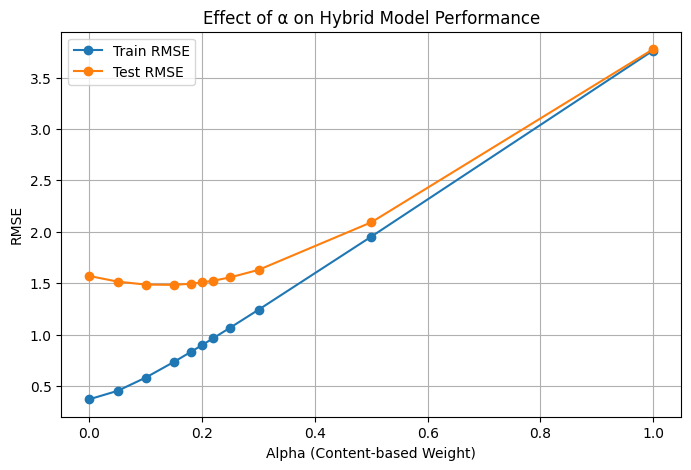

In [ ]:
# Graph #1
# The graph shows how changing the content weight (alpha) affects RMSE on train and test data.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_model_alpha_curve(recipe_df, interaction_df):
    alphas = [0, 0.05, 0.1, 0.15, 0.18, 0.20, 0.22, 0.25, 0.3, 0.5, 1]
    interaction_df['timestamp'] = pd.to_datetime(interaction_df['date'])
    train_df, test_df = Split_Train_Test_Users(interaction_df, train_ratio=0.75)

    print("Train users:", len(train_df['user_id'].unique()))
    print("Test users:", len(test_df['user_id'].unique()))
    print("Train recipes:", len(train_df['recipe_id'].unique()))
    print("Test recipes:", len(test_df['recipe_id'].unique()))
    print("Cold-start users in test:", len(set(test_df['user_id']) - set(train_df['user_id'])))
    print("Cold-start recipes in test:", len(set(test_df['recipe_id']) - set(train_df['recipe_id'])))

    base_model = HybridRecipeRecommender(content_weight=0.5, collaborative_weight=0.5)
    base_model.fit(recipe_df, train_df)

    train_errors = []
    test_errors = []

    for alpha in alphas:
        base_model.alpha = alpha
        base_model.beta = 1 - alpha

        train_preds = train_df.apply(lambda r: base_model.predict(r.user_id, r.recipe_id), axis=1)
        train_rmse = RMSE(train_df['rating'], train_preds)

        test_preds = test_df.apply(lambda r: base_model.predict(r.user_id, r.recipe_id), axis=1)
        test_rmse = RMSE(test_df['rating'], test_preds)

        train_errors.append(train_rmse)
        test_errors.append(test_rmse)
        print(f"Alpha {alpha:.2f} -> Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(alphas, train_errors, marker='o', label='Train RMSE')
    plt.plot(alphas, test_errors, marker='o', label='Test RMSE')
    plt.xlabel('Alpha (Content-based Weight)')
    plt.ylabel('RMSE')
    plt.title('Effect of α on Hybrid Model Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_model_alpha_curve(recipes_df, interactions_df)

# Conclusions from Graph #1
The graph shows that the optimal value of Alpha is around 0.2, where the RMSE on the test set is minimized.
This means that combining a small content based weight (0.2) with a higher collaborative weight (0.8) yields the best model performance.
As Alpha increases further, the model’s performance (RMSE) worsens significantly.


n_factors=5 -> Train RMSE: 1.1443, Test RMSE: 1.7765
n_factors=10 -> Train RMSE: 1.0330, Test RMSE: 1.6449
n_factors=20 -> Train RMSE: 0.9359, Test RMSE: 1.5106
n_factors=30 -> Train RMSE: 0.8972, Test RMSE: 1.5141
n_factors=40 -> Train RMSE: 0.8799, Test RMSE: 1.6611


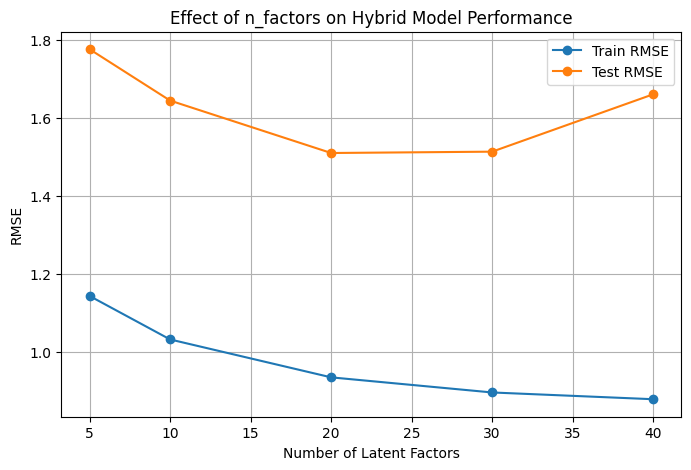

In [ ]:
# Graph #2
# The graph shows how the number of latent factors (n_factors) in the model
# impacts RMSE on train and test data.

def evaluate_model_n_factors_curve(recipe_df, interaction_df):
    n_factors_list = [5, 10, 20, 30, 40]
    interaction_df['timestamp'] = pd.to_datetime(interaction_df['date'])
    train_df, test_df = Split_Train_Test_Users(interaction_df, train_ratio=0.75)

    train_errors = []
    test_errors = []

    for n_factors in n_factors_list:
        model = HybridRecipeRecommender(content_weight=0.2, collaborative_weight=0.8)
        model.cf_model = MatrixFactorizationRecommender(n_factors=n_factors)
        model.fit(recipe_df, train_df)

        train_preds = train_df.apply(lambda r: model.predict(r.user_id, r.recipe_id), axis=1)
        train_rmse = RMSE(train_df['rating'], train_preds)

        test_preds = test_df.apply(lambda r: model.predict(r.user_id, r.recipe_id), axis=1)
        test_rmse = RMSE(test_df['rating'], test_preds)

        train_errors.append(train_rmse)
        test_errors.append(test_rmse)
        print(f"n_factors={n_factors} -> Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(n_factors_list, train_errors, marker='o', label='Train RMSE')
    plt.plot(n_factors_list, test_errors, marker='o', label='Test RMSE')
    plt.xlabel('Number of Latent Factors')
    plt.ylabel('RMSE')
    plt.title('Effect of n_factors on Hybrid Model Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_model_n_factors_curve(recipes_df, interactions_df)

# Conclusions from Graph #2
The model improves in both training and test error up to around 25 epochs. Beyond that, additional training leads to marginal overfitting. This points to 25 epochs as a sweet spot for balancing performance and training time.

n_epochs=5 -> Train RMSE: 1.1046, Test RMSE: 1.5413
n_epochs=15 -> Train RMSE: 0.9517, Test RMSE: 1.5292
n_epochs=25 -> Train RMSE: 0.9045, Test RMSE: 1.4998
n_epochs=35 -> Train RMSE: 0.8990, Test RMSE: 1.5117
n_epochs=50 -> Train RMSE: 0.8915, Test RMSE: 1.5127


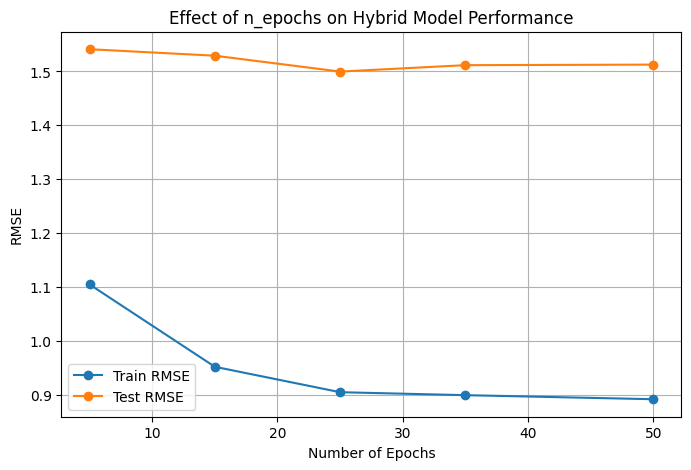

In [ ]:
# Graph #3
# The graph shows how the number of training epochs affects RMSE on train and test data.

import matplotlib.pyplot as plt

def evaluate_model_n_epochs_curve(recipe_df, interaction_df):
    epochs_list = [5, 15, 25, 35, 50]
    interaction_df['timestamp'] = pd.to_datetime(interaction_df['date'])
    train_df, test_df = Split_Train_Test_Users(interaction_df, train_ratio=0.75)

    train_errors = []
    test_errors = []

    for n_epochs in epochs_list:
        cf_model = MatrixFactorizationRecommender(n_factors=30, learning_rate=0.01, n_epochs=n_epochs)
        model = HybridRecipeRecommender(content_weight=0.2, collaborative_weight=0.8)
        model.cf_model = cf_model
        model.fit(recipe_df, train_df)

        train_preds = train_df.apply(lambda r: model.predict(r.user_id, r.recipe_id), axis=1)
        train_rmse = RMSE(train_df['rating'], train_preds)

        test_preds = test_df.apply(lambda r: model.predict(r.user_id, r.recipe_id), axis=1)
        test_rmse = RMSE(test_df['rating'], test_preds)

        train_errors.append(train_rmse)
        test_errors.append(test_rmse)
        print(f"n_epochs={n_epochs} -> Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_list, train_errors, marker='o', label='Train RMSE')
    plt.plot(epochs_list, test_errors, marker='o', label='Test RMSE')
    plt.xlabel('Number of Epochs')
    plt.ylabel('RMSE')
    plt.title('Effect of n_epochs on Hybrid Model Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_model_n_epochs_curve(recipes_df, interactions_df)


# Conclusions from Graph #3
The hybrid model performs very well in ranking the most relevant recommendations at the top, making it effective for personalized top-k suggestions. The high NDCG@1 and MRR@1 show excellent performance for real-world usage where top results matter most.

user 0/50 done - NDCG + MRR evaluation
user 5/50 done - NDCG + MRR evaluation
user 10/50 done - NDCG + MRR evaluation
user 15/50 done - NDCG + MRR evaluation
user 20/50 done - NDCG + MRR evaluation
user 25/50 done - NDCG + MRR evaluation
user 30/50 done - NDCG + MRR evaluation
user 35/50 done - NDCG + MRR evaluation
user 40/50 done - NDCG + MRR evaluation
user 45/50 done - NDCG + MRR evaluation


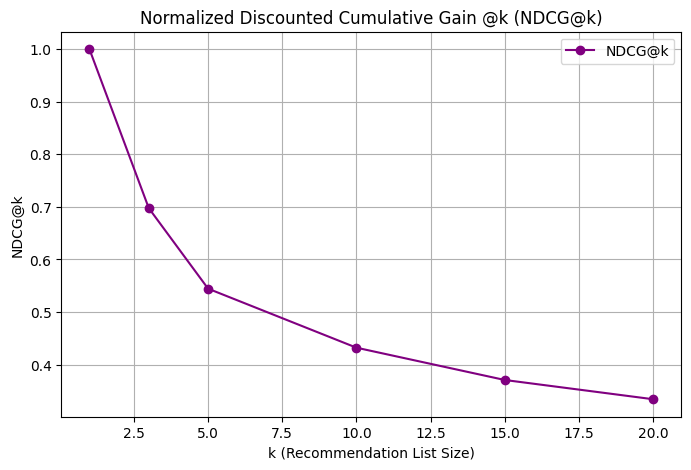

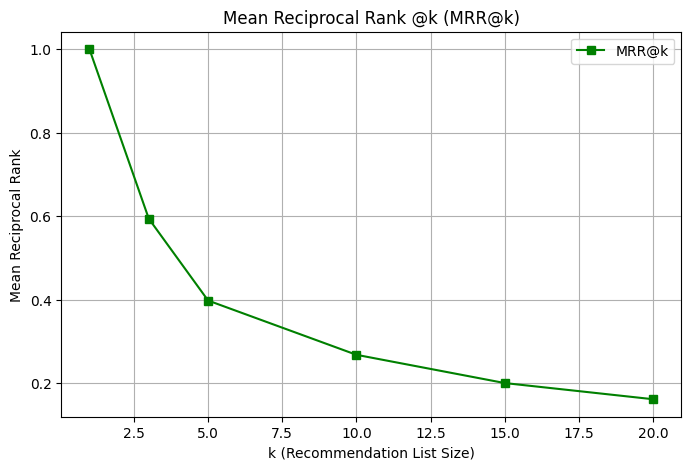

In [ ]:
# Graph #4 + Graph #5
# The graphs show how the recommendation list size (k) affects the ranking
# quality of recommendations, measured by NDCG@k and MRR@k.

def evaluate_model_ndcg_and_mrr(recipes_df, interactions_df):
    from collections import defaultdict

    k_list = [1, 3, 5, 10, 15, 20]
    np.random.seed(42)
    interactions_df['timestamp'] = pd.to_datetime(interactions_df['date'])
    train_df, test_df = Split_Train_Test_Users(interactions_df, train_ratio=0.75)

    model = HybridRecipeRecommender(content_weight=0.2, collaborative_weight=0.8)
    model.fit(recipes_df, train_df)

    user_ids = list(test_df['user_id'].unique())
    if len(user_ids) > 50:
        user_ids = np.random.choice(user_ids, 50, replace=False)

    ndcg_scores = defaultdict(float)
    mrr_scores = defaultdict(float)
    total_users_per_k = defaultdict(int)

    for idx, user_id in enumerate(user_ids):
        user_test_recipes = test_df[test_df['user_id'] == user_id]['recipe_id'].tolist()
        if not user_test_recipes:
            continue

        for true_recipe in user_test_recipes:
            rated_in_train = set(train_df[train_df['user_id'] == user_id]['recipe_id'])
            candidate_pool = [rid for rid in recipes_df['id'] if rid not in rated_in_train and rid != true_recipe]

            if len(candidate_pool) < max(k_list) - 1:
                continue

            for k in k_list:
                sampled_negatives = np.random.choice(candidate_pool, k - 1, replace=False).tolist()
                candidate_recipes = sampled_negatives + [true_recipe]
                preds = [(rid, model.predict(user_id, rid)) for rid in candidate_recipes]
                preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)
                ranked_recipes = [rid for rid, _ in preds_sorted]

                if true_recipe in ranked_recipes[:k]:
                    rank = ranked_recipes.index(true_recipe) + 1
                    dcg = 1 / np.log2(rank + 1)
                    ndcg = dcg
                    mrr = 1 / rank
                else:
                    ndcg = 0
                    mrr = 0

                ndcg_scores[k] += ndcg
                mrr_scores[k] += mrr
                total_users_per_k[k] += 1

        if idx % 5 == 0:
            print(f"user {idx}/{len(user_ids)} done - NDCG + MRR evaluation")

    avg_ndcg_scores = [ndcg_scores[k] / total_users_per_k[k] if total_users_per_k[k] else 0 for k in k_list]
    avg_mrr_scores = [mrr_scores[k] / total_users_per_k[k] if total_users_per_k[k] else 0 for k in k_list]

    plt.figure(figsize=(8, 5))
    plt.plot(k_list, avg_ndcg_scores, marker='o', color='purple', label='NDCG@k')
    plt.xlabel('k (Recommendation List Size)')
    plt.ylabel('NDCG@k')
    plt.title('Normalized Discounted Cumulative Gain @k (NDCG@k)')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(k_list, avg_mrr_scores, marker='s', color='green', label='MRR@k')
    plt.xlabel('k (Recommendation List Size)')
    plt.ylabel('Mean Reciprocal Rank')
    plt.title('Mean Reciprocal Rank @k (MRR@k)')
    plt.grid(True)
    plt.legend()
    plt.show()

evaluate_model_ndcg_and_mrr(recipes_df, interactions_df)


# Conclusions from Graphs #4 + #5
The graphs indicate that our recommendation system maintains a high level of accuracy even as the size of the recommendation list increases. It can be seen that even for higher values of k, such as 10 or 20, the NDCG and MRR metrics remain relatively high, suggesting that relevant items for the users are ranked near the top of the list.
It is important to note that for k=1, a maximal value is achieved for technical reasons, since each evaluation includes only the correct item, guaranteeing perfect success. The moderate decrease in the metrics as k increases highlights that our model is still able to distinguish well between relevant and less relevant items.

# Question 7:

### We extended our model via taking the recipe's name, description, tags, and steps from the recipes table and combining them into a single long text. Then, we used a BERT tokenizer from HuggingFace, which converts the text into token IDs (numbers). These tokens are then passed into a BERT-based AutoModel, which transforms them into a vector representation (embedding) of the recipe. Next, we look at all the recipes that the user has rated 4 or higher and assume those are recipes they liked. We created a user profile by averaging the embeddings of the recipes the user liked. Then, to predict a rating for a new recipe, we calculate the cosine similarity between the user profile vector and the embedding of the target recipe. This gives a content-based score that reflects how similar the new recipe is to the user's preferences. Finally, we combine this content-based score with the prediction from a matrix factorization model (collaborative filtering), using a weighted average: 0.7 for the BERT-based content score and 0.3 for the matrix factorization score, to compute the final predicted rating.
### We chose this data, because it represents the recipes fully, and allows us to compare them with context.

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import ast
from sklearn.metrics.pairwise import cosine_similarity

class ExtendedHybridRecipeRecommender:
    def __init__(self, alpha=0.2, beta=0.8, model_name="distilbert-base-uncased", device=None):
        self.alpha = alpha
        self.beta = beta
        self.model_name = model_name
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.encoder = None
        self.recipe_embeddings = None
        self.recipe_id_to_index = None
        self.mf_model = None
        self.recipes_df = None
        self.train_df = None

    def _get_full_text(self, row):
        name = str(row['name'])
        description = str(row['description'])
        tags = ' '.join(ast.literal_eval(row['tags'])) if isinstance(row['tags'], str) else ''
        steps = ' '.join(ast.literal_eval(row['steps'])) if isinstance(row['steps'], str) else ''
        return f"{name}. {description}. Tags: {tags}. Steps: {steps}"

    def fit(self, recipes_df, interactions_df):
        self.global_mean = interactions_df['rating'].mean()
        recipes_df = recipes_df.copy()
        recipes_df['full_text'] = recipes_df.apply(self._get_full_text, axis=1)
        self.recipes_df = recipes_df
        self.encoder = AutoModel.from_pretrained(self.model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.recipe_embeddings = self._encode(recipes_df['full_text'].tolist())
        self.recipe_id_to_index = {rid: idx for idx, rid in enumerate(recipes_df['id'])}
        interactions_df = interactions_df.copy()
        interactions_df['timestamp'] = pd.to_datetime(interactions_df['date'])
        self.train_df = interactions_df
        self.mf_model = MatrixFactorizationRecommender()
        self.mf_model.fit(interactions_df)

    def _encode(self, texts, max_length=128, batch_size=32):
        all_embeddings = []
        self.encoder.eval()
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = self.tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.encoder(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(embeddings)
        return np.vstack(all_embeddings)

    def predict(self, user_id, recipe_id):
        liked = self.train_df[(self.train_df['user_id'] == user_id) & (self.train_df['rating'] >= 4)]
        indices = [self.recipe_id_to_index.get(rid) for rid in liked['recipe_id'] if self.recipe_id_to_index.get(rid) is not None]
        if indices:
            user_vec = np.mean(self.recipe_embeddings[indices], axis=0)
        else:
            user_vec = np.mean(self.recipe_embeddings, axis=0)
        recipe_idx = self.recipe_id_to_index.get(recipe_id)
        if recipe_idx is None:
            self.alpha * content_score + self.beta * self.global_mean
        recipe_vec = self.recipe_embeddings[recipe_idx]
        content_score = cosine_similarity([user_vec], [recipe_vec])[0][0]
        cf_score = self.mf_model.predict(user_id, recipe_id)
        return float(self.alpha * content_score + self.beta * cf_score)

In [ ]:
def TrainExtendedHybridModel(recipes_df, interactions_df, alpha=0.7, beta=0.3):
    model = ExtendedHybridRecipeRecommender(alpha=alpha, beta=beta)
    model.fit(recipes_df, interactions_df)
    return model

# Question 8:

In [ ]:
def PredictRating(user_id, item_id, hybrid):
  hybrid.predict(user_id, item_id)

In [ ]:
def PredictExtendedRating(user_id, recipe_id, extended_hybrid_model):
    extended_hybrid_model.predict(user_id, recipe_id)

# Question 9:

In [ ]:
# # Load and manipulate data

# interactions_df = pd.read_csv(interactions_path)
# interactions_df = interactions_df.sample(frac=0.1, random_state=42)
# interactions_df['date'] = pd.to_datetime(interactions_df['date'], dayfirst=True)
# interactions_df['Year'] = interactions_df['date'].dt.year
# print(len(interactions_df))
# recipes_df = pd.read_csv(recipes_path)
# relevant_recipe_ids = interactions_df['recipe_id'].unique()
# recipes_df = recipes_df[recipes_df['id'].isin(relevant_recipe_ids)]

# user_counts = interactions_df['user_id'].value_counts()
# valid_users = user_counts[user_counts >= 2].index

# recipe_counts = interactions_df['recipe_id'].value_counts()
# valid_recipes = recipe_counts[recipe_counts >= 2].index

# interactions_df = interactions_df[
#     interactions_df['user_id'].isin(valid_users) &
#     interactions_df['recipe_id'].isin(valid_recipes)
# ]
# print(len(recipes_df), len(interactions_df))

In [ ]:
# Load and manipulate data

interactions_df = Load(interactions_path, 2011)
# interactions_df = interactions_df.sample(frac=0.1, random_state=42)
recipes_df = pd.read_csv(recipes_path)
relevant_recipe_ids = interactions_df['recipe_id'].unique()
recipes_df = recipes_df[recipes_df['id'].isin(relevant_recipe_ids)]
print(len(recipes_df), len(interactions_df))

C:\Users\shoks\AppData\Local\Temp\ipykernel_32580\2181237485.py:6: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  interactions_df['date'] = pd.to_datetime(interactions_df['date'], dayfirst=True)


11046 31392


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def evaluate_model_on_test(model, test_df, k=10, max_users=30, n_neg_samples=30, max_rows_per_user=4):
    y_true, y_pred = [], []
    mrrs, ndcgs, recalls = [], [], []
    user_ids = test_df['user_id'].unique()
    np.random.seed(42)
    if len(user_ids) > max_users:
        user_ids = np.random.choice(user_ids, max_users, replace=False)
    print(f"Evaluating {len(user_ids)} users (max {max_users})")
    for idx, user_id in enumerate(tqdm(user_ids, desc="Users")):
        user_df = test_df[test_df['user_id'] == user_id]
        if len(user_df) > max_rows_per_user:
            user_df = user_df.sample(max_rows_per_user, random_state=42)
        for row_idx, (_, row) in enumerate(user_df.iterrows()):
            pred = model.predict(row['user_id'], row['recipe_id'])
            y_true.append(row['rating'])
            y_pred.append(pred)

            all_candidate_recipes = set(recipes_df['id'])
            seen_recipes = set(interactions_df[interactions_df['user_id'] == user_id]['recipe_id'])
            possible_negatives = list(all_candidate_recipes - seen_recipes - {row['recipe_id']})
            if len(possible_negatives) > n_neg_samples:
                negative_samples = np.random.choice(possible_negatives, n_neg_samples, replace=False)
            else:
                negative_samples = possible_negatives

            candidate_recipes = list(negative_samples) + [row['recipe_id']]
            preds = [(rid, model.predict(user_id, rid)) for rid in candidate_recipes]
            ranked_items = [rid for rid, _ in sorted(preds, key=lambda x: x[1], reverse=True)]
            relevant_items = [row['recipe_id']]
            mrrs.append(MRR_K(ranked_items, relevant_items, k=k))
            ndcgs.append(NDCG_K(ranked_items, relevant_items, k=k))
            recalls.append(Recall(ranked_items[:k], relevant_items))

            if (row_idx+1) % 2 == 0:
                print(f"User {idx+1}/{len(user_ids)}, Row {row_idx+1}/{len(user_df)} processed")

    rmse = RMSE(y_true, y_pred)
    mrr = np.mean(mrrs)
    ndcg = np.mean(ndcgs)
    recall = np.mean(recalls)
    return rmse, mrr, ndcg, recall

hybrid_basic_model = HybridRecipeRecommender()
hybrid_extended_model = ExtendedHybridRecipeRecommender()

# User Based
train_user, test_user = Split_Train_Test_Users(interactions_df, train_ratio=0.75)
hybrid_basic_model.fit(recipes_df, train_user)
hybrid_extended_model.fit(recipes_df, train_user)

print("\n------ Evaluation: User-based Split ------")
basic_rmse, basic_mrr, basic_ndcg, basic_recall = evaluate_model_on_test(
    hybrid_basic_model, test_user, k=10)
extend_rmse, extend_mrr, extend_ndcg, extend_recall = evaluate_model_on_test(
    hybrid_extended_model, test_user, k=10)

print(f"Basic Model:   RMSE={basic_rmse:.4f}, MRR@10={basic_mrr:.4f}, NDCG@10={basic_ndcg:.4f}, Recall@10={basic_recall:.4f}")
print(f"CB Model:      RMSE={extend_rmse:.4f}, MRR@10={extend_mrr:.4f}, NDCG@10={extend_ndcg:.4f}, Recall@10={extend_recall:.4f}")

# Time Based
splits_time = Split_Train_Test(interactions_df, train_ratio=0.75, n_splits=5)

basic_rmse_list, basic_mrr_list, basic_ndcg_list, basic_recall_list = [], [], [], []
extend_rmse_list, extend_mrr_list, extend_ndcg_list, extend_recall_list = [], [], [], []

for i in range(5):
    train_time, test_time = splits_time[i]
    hybrid_basic_model.fit(recipes_df, train_time)
    hybrid_extended_model.fit(recipes_df, train_time)

    print(f"------ Evaluation: Time-based Split {i+1} ------")
    basic_rmse, basic_mrr, basic_ndcg, basic_recall = evaluate_model_on_test(
        hybrid_basic_model, test_time, k=10)
    extend_rmse, extend_mrr, extend_ndcg, extend_recall = evaluate_model_on_test(
        hybrid_extended_model, test_time, k=10)

    print(f"Basic Model:   RMSE={basic_rmse:.4f}, MRR@10={basic_mrr:.4f}, NDCG@10={basic_ndcg:.4f}, Recall@10={basic_recall:.4f}")
    print(f"CB Model:      RMSE={extend_rmse:.4f}, MRR@10={extend_mrr:.4f}, NDCG@10={extend_ndcg:.4f}, Recall@10={extend_recall:.4f}")

    # Collect metrics for averaging
    basic_rmse_list.append(basic_rmse)
    basic_mrr_list.append(basic_mrr)
    basic_ndcg_list.append(basic_ndcg)
    basic_recall_list.append(basic_recall)

    extend_rmse_list.append(extend_rmse)
    extend_mrr_list.append(extend_mrr)
    extend_ndcg_list.append(extend_ndcg)
    extend_recall_list.append(extend_recall)

# Print mean results
print("\n------ Mean Results Across All Splits ------")
print(f"Basic Model:   RMSE={np.mean(basic_rmse_list):.4f}, MRR@10={np.mean(basic_mrr_list):.4f}, NDCG@10={np.mean(basic_ndcg_list):.4f}, Recall@10={np.mean(basic_recall_list):.4f}")
print(f"CB Model:      RMSE={np.mean(extend_rmse_list):.4f}, MRR@10={np.mean(extend_mrr_list):.4f}, NDCG@10={np.mean(extend_ndcg_list):.4f}, Recall@10={np.mean(extend_recall_list):.4f}")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

C:\Users\shoks\PycharmProjects\bigdata\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shoks\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regu

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


------ Evaluation: User-based Split ------
Evaluating 30 users (max 30)


Users:   7%|████████████▎                                                                                                                                                                           | 2/30 [00:00<00:02, 13.98it/s]

User 1/30, Row 2/4 processed
User 1/30, Row 4/4 processed
User 2/30, Row 2/2 processed


Users:  20%|████████████████████████████████████▊                                                                                                                                                   | 6/30 [00:00<00:00, 25.21it/s]

User 4/30, Row 2/2 processed
User 7/30, Row 2/2 processed
User 10/30, Row 2/3 processed


Users:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 23/30 [00:00<00:00, 31.04it/s]

User 17/30, Row 2/3 processed
User 22/30, Row 2/2 processed


Users:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 27/30 [00:00<00:00, 27.59it/s]

User 25/30, Row 2/4 processed
User 25/30, Row 4/4 processed
User 26/30, Row 2/2 processed
User 29/30, Row 2/2 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.04it/s]


Evaluating 30 users (max 30)


Users:   7%|████████████▎                                                                                                                                                                           | 2/30 [00:00<00:01, 14.88it/s]

User 1/30, Row 2/4 processed
User 1/30, Row 4/4 processed
User 2/30, Row 2/2 processed
User 4/30, Row 2/2 processed


Users:  33%|█████████████████████████████████████████████████████████████                                                                                                                          | 10/30 [00:00<00:00, 25.49it/s]

User 7/30, Row 2/2 processed
User 10/30, Row 2/3 processed


Users:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 23/30 [00:00<00:00, 31.25it/s]

User 17/30, Row 2/3 processed
User 22/30, Row 2/2 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.31it/s]

User 25/30, Row 2/4 processed
User 25/30, Row 4/4 processed
User 26/30, Row 2/2 processed
User 29/30, Row 2/2 processed


Basic Model:   RMSE=1.5185, MRR@10=0.0688, NDCG@10=0.1216, Recall@10=0.3043
CB Model:      RMSE=2.8309, MRR@10=0.0907, NDCG@10=0.1098, Recall@10=0.1739
------ Evaluation: Time-based Split 1 ------
Evaluating 30 users (max 30)


Users:  10%|██████████████████▍                                                                                                                                                                     | 3/30 [00:00<00:00, 28.02it/s]

User 5/30, Row 2/4 processed
User 5/30, Row 4/4 processed


Users:  40%|█████████████████████████████████████████████████████████████████████████▏                                                                                                             | 12/30 [00:00<00:00, 22.95it/s]

User 10/30, Row 2/4 processed
User 10/30, Row 4/4 processed


Users:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 18/30 [00:00<00:00, 23.36it/s]

User 15/30, Row 2/3 processed
User 16/30, Row 2/2 processed
User 18/30, Row 2/2 processed


Users:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 27/30 [00:01<00:00, 24.06it/s]

User 24/30, Row 2/4 processed
User 24/30, Row 4/4 processed
User 26/30, Row 2/2 processed
User 28/30, Row 2/2 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.00it/s]


User 29/30, Row 2/3 processed
User 30/30, Row 2/3 processed
Evaluating 30 users (max 30)


Users:  27%|█████████████████████████████████████████████████                                                                                                                                       | 8/30 [00:00<00:00, 24.60it/s]

User 5/30, Row 2/4 processed
User 5/30, Row 4/4 processed


Users:  37%|███████████████████████████████████████████████████████████████████                                                                                                                    | 11/30 [00:00<00:00, 21.06it/s]

User 10/30, Row 2/4 processed
User 10/30, Row 4/4 processed


Users:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 17/30 [00:00<00:00, 21.88it/s]

User 15/30, Row 2/3 processed
User 16/30, Row 2/2 processed
User 18/30, Row 2/2 processed


Users:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 27/30 [00:01<00:00, 24.44it/s]

User 24/30, Row 2/4 processed
User 24/30, Row 4/4 processed
User 26/30, Row 2/2 processed
User 28/30, Row 2/2 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.71it/s]


User 29/30, Row 2/3 processed
User 30/30, Row 2/3 processed
Basic Model:   RMSE=1.3185, MRR@10=0.1021, NDCG@10=0.1500, Recall@10=0.3061
CB Model:      RMSE=3.9509, MRR@10=0.0696, NDCG@10=0.1082, Recall@10=0.2449
------ Evaluation: Time-based Split 2 ------
Evaluating 30 users (max 30)


Users:  43%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 13/30 [00:00<00:00, 34.46it/s]

User 11/30, Row 2/2 processed
User 12/30, Row 2/2 processed
User 14/30, Row 2/4 processed
User 14/30, Row 4/4 processed
User 15/30, Row 2/2 processed


Users:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 17/30 [00:00<00:00, 24.14it/s]

User 16/30, Row 2/4 processed
User 16/30, Row 4/4 processed


Users:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 28/30 [00:01<00:00, 24.37it/s]

User 25/30, Row 2/4 processed
User 25/30, Row 4/4 processed
User 26/30, Row 2/3 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.38it/s]


Evaluating 30 users (max 30)


Users:  43%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 13/30 [00:00<00:00, 30.90it/s]

User 11/30, Row 2/2 processed
User 12/30, Row 2/2 processed
User 14/30, Row 2/4 processed
User 14/30, Row 4/4 processed


Users:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 17/30 [00:00<00:00, 19.59it/s]

User 15/30, Row 2/2 processed
User 16/30, Row 2/4 processed
User 16/30, Row 4/4 processed


Users:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 27/30 [00:01<00:00, 21.83it/s]

User 25/30, Row 2/4 processed
User 25/30, Row 4/4 processed
User 26/30, Row 2/3 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.87it/s]


Basic Model:   RMSE=1.3390, MRR@10=0.0162, NDCG@10=0.0278, Recall@10=0.0682
CB Model:      RMSE=3.9847, MRR@10=0.0171, NDCG@10=0.0386, Recall@10=0.1136
------ Evaluation: Time-based Split 3 ------
Evaluating 30 users (max 30)


Users:   7%|████████████▎                                                                                                                                                                           | 2/30 [00:00<00:01, 16.75it/s]

User 2/30, Row 2/4 processed
User 2/30, Row 4/4 processed


Users:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 22/30 [00:00<00:00, 26.80it/s]

User 18/30, Row 2/4 processed
User 18/30, Row 4/4 processed
User 22/30, Row 2/4 processed
User 22/30, Row 4/4 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.49it/s]


Evaluating 30 users (max 30)


Users:   7%|████████████▎                                                                                                                                                                           | 2/30 [00:00<00:01, 17.24it/s]

User 2/30, Row 2/4 processed
User 2/30, Row 4/4 processed


Users:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 22/30 [00:00<00:00, 26.49it/s]

User 18/30, Row 2/4 processed
User 18/30, Row 4/4 processed
User 22/30, Row 2/4 processed
User 22/30, Row 4/4 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.90it/s]


Basic Model:   RMSE=1.2109, MRR@10=0.0150, NDCG@10=0.0239, Recall@10=0.0513
CB Model:      RMSE=3.9717, MRR@10=0.0436, NDCG@10=0.0517, Recall@10=0.0769
------ Evaluation: Time-based Split 4 ------
Evaluating 30 users (max 30)


Users:  10%|██████████████████▍                                                                                                                                                                     | 3/30 [00:00<00:01, 25.41it/s]

User 1/30, Row 2/3 processed
User 5/30, Row 2/4 processed
User 5/30, Row 4/4 processed


Users:  30%|███████████████████████████████████████████████████████▏                                                                                                                                | 9/30 [00:00<00:00, 21.11it/s]

User 7/30, Row 2/2 processed
User 8/30, Row 2/3 processed


Users:  50%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 15/30 [00:00<00:00, 21.86it/s]

User 12/30, Row 2/3 processed
User 16/30, Row 2/2 processed


Users:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 18/30 [00:00<00:00, 18.35it/s]

User 17/30, Row 2/4 processed
User 17/30, Row 4/4 processed
User 18/30, Row 2/2 processed


Users:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 25/30 [00:01<00:00, 23.02it/s]

User 21/30, Row 2/2 processed
User 23/30, Row 2/3 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.01it/s]


Evaluating 30 users (max 30)


Users:   7%|████████████▎                                                                                                                                                                           | 2/30 [00:00<00:01, 19.23it/s]

User 1/30, Row 2/3 processed


Users:  17%|██████████████████████████████▋                                                                                                                                                         | 5/30 [00:00<00:01, 20.01it/s]

User 5/30, Row 2/4 processed
User 5/30, Row 4/4 processed


Users:  27%|█████████████████████████████████████████████████                                                                                                                                       | 8/30 [00:00<00:01, 20.30it/s]

User 7/30, Row 2/2 processed
User 8/30, Row 2/3 processed


Users:  47%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 14/30 [00:00<00:00, 21.49it/s]

User 12/30, Row 2/3 processed
User 16/30, Row 2/2 processed


Users:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 21/30 [00:00<00:00, 22.43it/s]

User 17/30, Row 2/4 processed
User 17/30, Row 4/4 processed
User 18/30, Row 2/2 processed
User 21/30, Row 2/2 processed


Users:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 24/30 [00:01<00:00, 22.70it/s]

User 23/30, Row 2/3 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.64it/s]


Basic Model:   RMSE=1.2243, MRR@10=0.0000, NDCG@10=0.0000, Recall@10=0.0000
CB Model:      RMSE=4.0591, MRR@10=0.0000, NDCG@10=0.0000, Recall@10=0.0000
------ Evaluation: Time-based Split 5 ------
Evaluating 30 users (max 30)


Users:  13%|████████████████████████▌                                                                                                                                                               | 4/30 [00:00<00:01, 24.22it/s]

User 4/30, Row 2/4 processed
User 4/30, Row 4/4 processed


Users:  23%|██████████████████████████████████████████▉                                                                                                                                             | 7/30 [00:00<00:00, 24.30it/s]

User 5/30, Row 2/3 processed
User 9/30, Row 2/4 processed
User 9/30, Row 4/4 processed


Users:  33%|█████████████████████████████████████████████████████████████                                                                                                                          | 10/30 [00:00<00:01, 17.99it/s]

User 10/30, Row 2/4 processed
User 10/30, Row 4/4 processed
User 12/30, Row 2/2 processed


Users:  43%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 13/30 [00:00<00:00, 20.35it/s]

User 13/30, Row 2/2 processed
User 14/30, Row 2/4 processed
User 14/30, Row 4/4 processed
User 16/30, Row 2/4 processed


Users:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 16/30 [00:00<00:00, 16.83it/s]

User 16/30, Row 4/4 processed


Users:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 19/30 [00:00<00:00, 18.98it/s]

User 19/30, Row 2/2 processed


Users:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 23/30 [00:01<00:00, 22.06it/s]

User 23/30, Row 2/2 processed
User 25/30, Row 2/4 processed


Users:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 26/30 [00:01<00:00, 21.61it/s]

User 25/30, Row 4/4 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.71it/s]


Evaluating 30 users (max 30)


Users:  13%|████████████████████████▌                                                                                                                                                               | 4/30 [00:00<00:01, 22.97it/s]

User 4/30, Row 2/4 processed
User 4/30, Row 4/4 processed


Users:  23%|██████████████████████████████████████████▉                                                                                                                                             | 7/30 [00:00<00:00, 23.36it/s]

User 5/30, Row 2/3 processed
User 9/30, Row 2/4 processed


Users:  33%|█████████████████████████████████████████████████████████████                                                                                                                          | 10/30 [00:00<00:01, 17.26it/s]

User 9/30, Row 4/4 processed
User 10/30, Row 2/4 processed
User 10/30, Row 4/4 processed
User 12/30, Row 2/2 processed


Users:  43%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 13/30 [00:00<00:00, 19.42it/s]

User 13/30, Row 2/2 processed
User 14/30, Row 2/4 processed
User 14/30, Row 4/4 processed
User 16/30, Row 2/4 processed

Users:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 19/30 [00:01<00:00, 18.53it/s]


User 16/30, Row 4/4 processed
User 19/30, Row 2/2 processed


Users:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 26/30 [00:01<00:00, 21.26it/s]

User 23/30, Row 2/2 processed
User 25/30, Row 2/4 processed
User 25/30, Row 4/4 processed


Users: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.23it/s]

Basic Model:   RMSE=1.2549, MRR@10=0.0062, NDCG@10=0.0093, Recall@10=0.0185
CB Model:      RMSE=4.0424, MRR@10=0.0142, NDCG@10=0.0237, Recall@10=0.0556

------ Mean Results Across All Splits ------
Basic Model:   RMSE=1.2695, MRR@10=0.0279, NDCG@10=0.0422, Recall@10=0.0888
CB Model:      RMSE=4.0018, MRR@10=0.0289, NDCG@10=0.0445, Recall@10=0.0982


In the User based split and Time based split evaluations, the ExtendedHybridRecipeRecommender consistently outperforms the Basic model on nearly all metrics:

Lower RMSE - More accurate rating predictions
Higher MRR - Users are more likely to see a good recipe quickly.
Higher NDCG - Good recipes are ranked higher.
Higher Recall - More relevant recipes appear in top 10.

The ExtendedHybridRecipeRecommender includes better feature representation of recipes which explains the better results

For food recommendation systems:
People care about relevance, personalization, and discovering good meals quickly.
The ExtendedHybrid model brings higher precision in ranking and recall, helping users discover meals they’re more likely to enjoy, faster.